In [13]:
# https://colab.research.google.com/drive/1tgBjmb39x-kC-xGW85Yopp7gnUb9r37_?usp=sharing
# imports
import skimage as sk
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
# plots images
def show_images(imgs, stitles, nrow, ncol, title=None):

  fig, axs = plt.subplots(nrows=nrow, ncols=ncol, constrained_layout=True)
  if title:
    fig.suptitle(title)

  for i, ax in enumerate(axs.flatten()):
    ax.imshow(imgs[i], cmap="gray")
    ax.set_title(stitles[i])
    ax.set_yticks([])
    ax.set_xticks([])

# NLM Demonstration

In [14]:
# URL or file path of image
PATH = "https://paco-cpu.github.io/paco-cpu/images/results/lut/lenna_128/lenna_128x128.png"
# Read image
img = sk.io.imread(PATH, as_gray=True).astype(np.float32)

In [21]:
# Non-local-mean denoising implementation
def nlm_denoise(img, h, patch_wsize=7, search_wsize=21):

  # pad the image
  padded_img = cv2.copyMakeBorder(img, search_wsize//2, search_wsize//2, search_wsize//2, search_wsize//2, cv2.BORDER_REPLICATE)

  # create empty matrix for resulting denoised image
  denoised_img = np.zeros_like(padded_img)

  # loop thorugh the image
  for i in range(search_wsize//2, padded_img.shape[0] - search_wsize//2):
    for j in range(search_wsize//2, padded_img.shape[1] - search_wsize//2):

      # find searching window of pixel
      pixel_nhood_w = padded_img[i-patch_wsize//2: i+patch_wsize//2+1, j-patch_wsize//2: j+patch_wsize//2+1]

      Z = 0       # total weight
      NL = 0      # intensity of pixel

      for k in range(i-search_wsize//2+patch_wsize//2, i+search_wsize//2 - patch_wsize//2):
        for l in range(j-search_wsize//2+patch_wsize//2, j+search_wsize//2 - patch_wsize//2):
          patch_w = padded_img[k-patch_wsize//2: k+patch_wsize//2+1, l-patch_wsize//2: l+patch_wsize//2+1]

          dist_eucl = np.linalg.norm(patch_w - pixel_nhood_w)

          # claculate weights
          w = np.exp(-(dist_eucl)/(h*h))

          Z+=w
          NL+= w*patch_w[patch_wsize//2, patch_wsize//2]

      NL/=Z

      # assign intensity to pixel
      denoised_img[i,j] = NL

  # return denoised image
  return denoised_img[search_wsize//2: -search_wsize//2+1, search_wsize//2: -search_wsize//2+1]


In [47]:
sigma = 0.05
noisy = sk.util.random_noise(img/255, "gaussian", var=sigma**2)
nlm = nlm_denoise(noisy, 10*sigma)

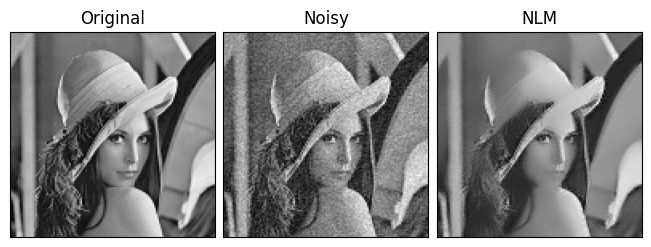

In [48]:
# plot
imgs = [img, noisy, nlm]
names = ["Original", "Noisy", "NLM"]
show_images(imgs, names, 1,3)

# Validation

### Comparing with other methods


In [49]:
gauss = cv2.GaussianBlur(noisy, (5,5), 35)
total_var = sk.restoration.denoise_tv_chambolle(noisy)
blur = cv2.blur(noisy, (5,5))

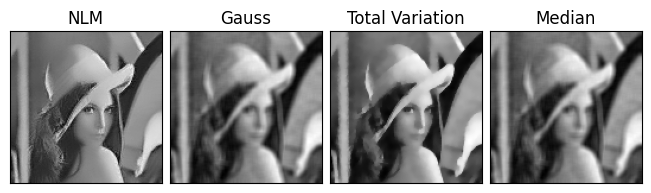

In [50]:
# plot
imgs = [nlm, gauss, total_var, blur]
names = ["NLM", "Gauss", "Total Variation", "Median"]
show_images(imgs, names, 1,4)

### Comparing effects of window size

In [51]:
nlm_3_15 = nlm_denoise(noisy, 10*sigma)
nlm_15_45 = nlm_denoise(noisy, 10*sigma)

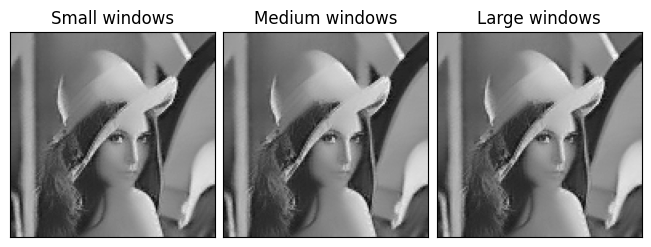

In [52]:
# plot
imgs = [nlm_3_15, nlm, nlm_15_45]
names = ["Small windows", "Medium windows", "Large windows"]
show_images(imgs, names, 1,3)

### different blurriness

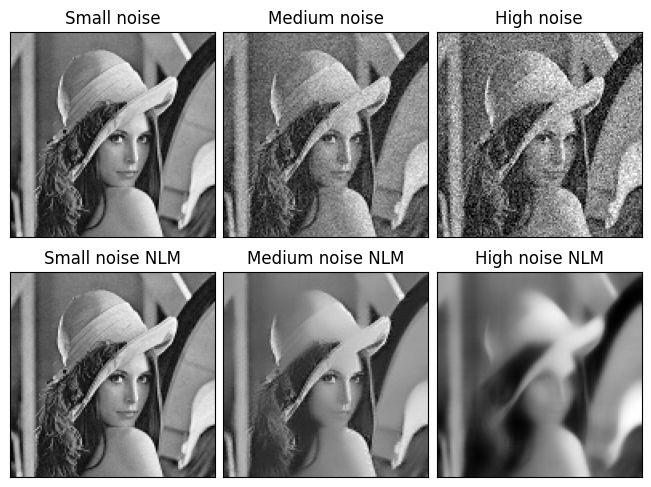

In [55]:
sigma_small = 0.01
noisy_small = sk.util.random_noise(img/255, "gaussian", var=sigma_small**2)
nlm_small = nlm_denoise(noisy_small, 10*sigma_small)

sigma_big = 0.1
noisy_big = sk.util.random_noise(img/255, "gaussian", var=sigma_big**2)
nlm_big = nlm_denoise(noisy, 10*sigma_big)

imgs = [noisy_small, noisy, noisy_big, nlm_small, nlm, nlm_big]
names = ["Small noise", "Medium noise", "High noise", "Small noise NLM", "Medium noise NLM", "High noise NLM"]
show_images(imgs, names, 2,3)
